# Moonshot 月度因子回测框架教程

本教程将演示如何使用Moonshot进行月度因子回测分析。我们将从最简单的示例开始，逐步展示更复杂的功能。

## 1. 导入必要的库

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from moonshot import Moonshot

plt.rcParams['axes.unicode_minus'] = False

print("Moonshot imported successfully！")

Moonshot imported successfully！


## 2. 示例1：最简单的验证示例（2资产，2个月）

我们首先创建一个最简单的示例，使用2个资产和2个月的数据。第一个月用来提取因子数据，第二个月用于交易计算收益。

我们使用简单的数字，便于手工验证计算结果的正确性。

In [23]:
# 创建简单的测试数据
factor_data = [
    (pd.Timestamp('2023-01-31'), "A", 1.0),
    (pd.Timestamp('2023-01-31'), "B", 2.0)
]

factor_df = pd.DataFrame(factor_data, columns=["date", "asset", "factor"]).set_index(["date", "asset"])

factor_df

factor
date       asset        
2023-01-31 A         1.0
           B         2.0

为了显示关键帧数据（月头、月尾），我们设计了以下函数：

In [24]:
def key_frames(bars, dates):
    df = dates.to_frame(name = "date")
    month_starts = df.resample('MS')['date'].first()
    month_ends = df.resample('BME')['date'].last()

    key_frames = bars[
        (bars.index.get_level_values(0).isin(month_ends) |
        bars.index.get_level_values(0).isin(month_starts))
    ]

    return key_frames

In [25]:
# 价格数据：简单的固定收益率
dates = pd.date_range('2023-01-01', '2023-02-28', freq='D')
prices = [("A", 100, 110), ("B", 100, 105)] * len(dates)

bars = pd.DataFrame(prices, columns=["asset", "open", "close"], 
                    index=np.repeat(dates, 2))
bars = bars.set_index([bars.index, 'asset'])
bars.index.names = ["date", "asset"]

display(key_frames(bars, dates).unstack())

print("Stock_A (因子=1.0): 收益率 = (110-100)/100 = 10%")
print("Stock_B (因子=2.0): 收益率 = (105-100)/100 = 5%")

print("Q1组 (因子较小): Stock_A, 收益率 = 10%")
print("Q2组 (因子较大): Stock_B, 收益率 = 5%")
print("benchmark = (10% + 5%) / 2 = 7.5%")

expected = pd.DataFrame([[0.075, 0.05, -0.05, 0.1]], 
                        columns=["benchmark", "long-only", "long-short", "optimal"], index=["2023-02-28"])
expected.style.background_gradient(cmap='RdYlGn')
expected.style.format("{:.2%}")

open      close     
asset         A    B     A    B
date                           
2023-01-01  100  100   110  105
2023-01-31  100  100   110  105
2023-02-01  100  100   110  105
2023-02-28  100  100   110  105

Stock_A (因子=1.0): 收益率 = (110-100)/100 = 10%
Stock_B (因子=2.0): 收益率 = (105-100)/100 = 5%
Q1组 (因子较小): Stock_A, 收益率 = 10%
Q2组 (因子较大): Stock_B, 收益率 = 5%
benchmark = (10% + 5%) / 2 = 7.5%


,benchmark,long-only,long-short,optimal
2023-02-28,7.50%,5.00%,-5.00%,10.00%


In [ ]:
# 价格数据：简单的固定收益率
dates = pd.date_range('2023-01-01', '2023-02-28', freq='D')
prices = [("A", 100, 110), ("B", 100, 105)] * len(dates)

bars = pd.DataFrame(prices, columns=["asset", "open", "close"], 
                    index=np.repeat(dates, 2))
bars = bars.set_index([bars.index, 'asset'])
bars.index.names = ["date", "asset"]

display(key_frames(bars, dates).unstack())

print("Stock_A (因子=1.0): 收益率 = (110-100)/100 = 10%")
print("Stock_B (因子=2.0): 收益率 = (105-100)/100 = 5%")

print("Q1组 (因子较小): Stock_A, 收益率 = 10%")
print("Q2组 (因子较大): Stock_B, 收益率 = 5%")
print("benchmark = (10% + 5%) / 2 = 7.5%")

expected = pd.DataFrame([[0.075, 0.05, -0.05, 0.1]], 
                        columns=["benchmark", "long-only", "long-short", "optimal"], index=["2023-02-28"])
expected.style.background_gradient(cmap='RdYlGn')
expected.style.format("{:.2%}")

open      close     
asset         A    B     A    B
date                           
2023-01-01  100  100   110  105
2023-01-31  100  100   110  105
2023-02-01  100  100   110  105
2023-02-28  100  100   110  105

Stock_A (因子=1.0): 收益率 = (110-100)/100 = 10%
Stock_B (因子=2.0): 收益率 = (105-100)/100 = 5%
Q1组 (因子较小): Stock_A, 收益率 = 10%
Q2组 (因子较大): Stock_B, 收益率 = 5%
benchmark = (10% + 5%) / 2 = 7.5%


,benchmark,long-only,long-short,optimal
2023-02-28,7.50%,5.00%,-5.00%,10.00%


In [26]:
moonshot = Moonshot()

# 执行回测（使用2个分位数）
moonshot.backtest(factor_df, bars, quantiles=2)

actual = pd.DataFrame([moonshot.benchmark_returns, 
                      moonshot.long_only_returns, 
                      moonshot.long_short_returns, 
                      moonshot.optimal_returns]).T

actual.columns = ["benchmark", "long-only", "long-short", "optimal"]
actual.style.format("{:.2%}")

,benchmark,long-only,long-short,optimal
2023-02-28 23:59:59.999999999,7.50%,5.00%,-5.00%,10.00%


In [22]:
bars

open  close
date       asset             
2023-01-01 A       100    110
           B       100    105
2023-01-02 A       100    110
           B       100    105
2023-01-03 A       100    110
...                ...    ...
2023-02-26 B       100    105
2023-02-27 A       100    110
           B       100    105
2023-02-28 A       100    110
           B       100    105

[118 rows x 2 columns]

## Returns in Quantiles

In [17]:
moonshot.quantile_returns

""


## 3. 示例2：中等复杂度示例（5资产，6个月，5个分位数）

现在我们创建一个更复杂的示例，使用5个资产和6个月的数据，按5个分位数进行分组。

In [7]:
# 创建5个资产，6个月的数据
dates_medium = pd.date_range('2023-01-01', '2023-06-30', freq='D')

assets = ['Stock_A', 'Stock_B', 'Stock_C', 'Stock_D', 'Stock_E']

# 因子数据：每月月末的因子值，具有明确的排序
factor_data_medium = []
factor_values = [1.0, 2.0, 3.0, 4.0, 5.0]  # 明确的因子排序

for month in pd.date_range('2023-01-31', '2023-05-31', freq='ME'):
    for i, asset in enumerate(assets):
        factor_data_medium.append({
            'date': month,
            'asset': asset,
            'factor': factor_values[i]
        })

factor_df_medium = pd.DataFrame(factor_data_medium)
factor_series_medium = factor_df_medium.set_index(['date', 'asset'])['factor']

print("因子数据（按月份和资产）:")
print(factor_series_medium.unstack())
print()

因子数据（按月份和资产）:
asset       Stock_A  Stock_B  Stock_C  Stock_D  Stock_E
date                                                   
2023-01-31      1.0      2.0      3.0      4.0      5.0
2023-02-28      1.0      2.0      3.0      4.0      5.0
2023-03-31      1.0      2.0      3.0      4.0      5.0
2023-04-30      1.0      2.0      3.0      4.0      5.0
2023-05-31      1.0      2.0      3.0      4.0      5.0



In [8]:
# 价格数据：收益率与因子值正相关
price_data_medium = []
base_returns = [0.02, 0.04, 0.06, 0.08, 0.10]  # 因子越高，收益率越高

df = dates_medium.to_frame(name = "date")
month_starts = df.resample('MS')['date'].first()
month_ends = df.resample('BME')['date'].last()

for start, end in zip(month_starts.values, month_ends.values):
    for i, asset in enumerate(assets):
        price_data_medium.append({
            'date': start,
            'asset': asset,
            'open': 100,
            'close': 100,
        })

        price_data_medium.append({
            'date': end,
            'asset': asset,
            'open': 100,
            'close': 100 * (1 + base_returns[i])
        })

bars_df_medium = pd.DataFrame(price_data_medium)
bars_medium = bars_df_medium.set_index(['date', 'asset'])

print("价格数据样本:")
key_frames(bars_medium, dates_medium).unstack()

价格数据样本:


open                                   close                  \
asset      Stock_A Stock_B Stock_C Stock_D Stock_E Stock_A Stock_B Stock_C   
date                                                                         
2023-01-01     100     100     100     100     100   100.0   100.0   100.0   
2023-01-31     100     100     100     100     100   102.0   104.0   106.0   
2023-02-01     100     100     100     100     100   100.0   100.0   100.0   
2023-02-28     100     100     100     100     100   102.0   104.0   106.0   
2023-03-01     100     100     100     100     100   100.0   100.0   100.0   
2023-03-31     100     100     100     100     100   102.0   104.0   106.0   
2023-04-01     100     100     100     100     100   100.0   100.0   100.0   
2023-04-28     100     100     100     100     100   102.0   104.0   106.0   
2023-05-01     100     100     100     100     100   100.0   100.0   100.0   
2023-05-31     100     100     100     100     100   102.0   104.0   106.0   
2023-06-01     100     100     100     100     100   100.0   100.0   100.0   
2023-06-30     100     100     100     100     100   102.0   104.0   106.0   

                            
asset      Stock_D Stock_E  
date                        
2023-01-01   100.0   100.0  
2023-01-31   108.0   110.0  
2023-02-01   100.0   100.0  
2023-02-28   108.0   110.0  
2023-03-01   100.0   100.0  
2023-03-31   108.0   110.0  
2023-04-01   100.0   100.0  
2023-04-28   108.0   110.0  
2023-05-01   100.0   100.0  
2023-05-31   108.0   110.0  
2023-06-01   100.0   100.0  
2023-06-30   108.0   110.0

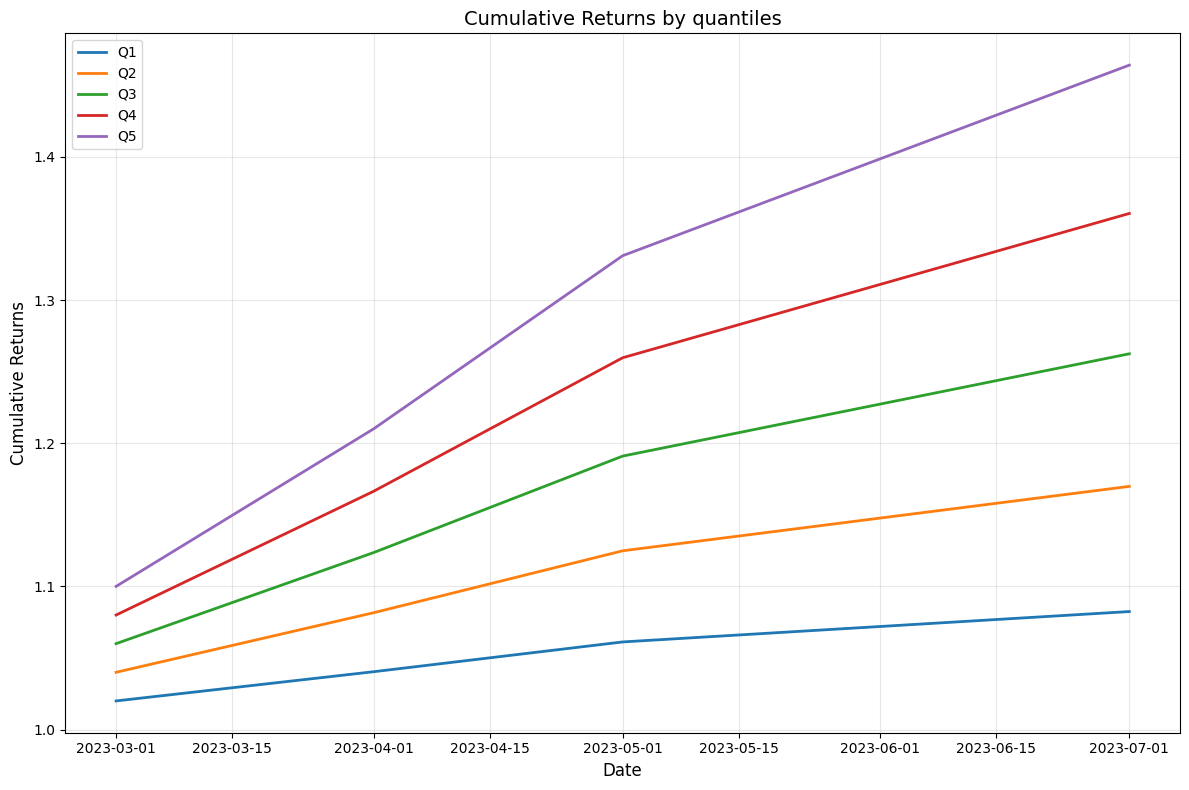

,Q1,Q2,Q3,Q4,Q5
2023-02-28 23:59:59.999999999,1.020000,1.040000,1.060000,1.080000,1.1000
2023-03-31 23:59:59.999999999,1.040400,1.081600,1.123600,1.166400,1.2100
2023-04-30 23:59:59.999999999,1.061208,1.124864,1.191016,1.259712,1.3310
2023-06-30 23:59:59.999999999,1.082432,1.169859,1.262477,1.360489,1.4641


In [9]:
# 使用Moonshot进行回测
moonshot_medium = Moonshot()

# 执行回测（使用5个分位数）
moonshot_medium.backtest(
    factor_series_medium, bars_medium, quantiles=5
)

moonshot_medium.plot_cumulative_returns_by_quantiles()
(1 + moonshot_medium.quantile_returns).cumprod()

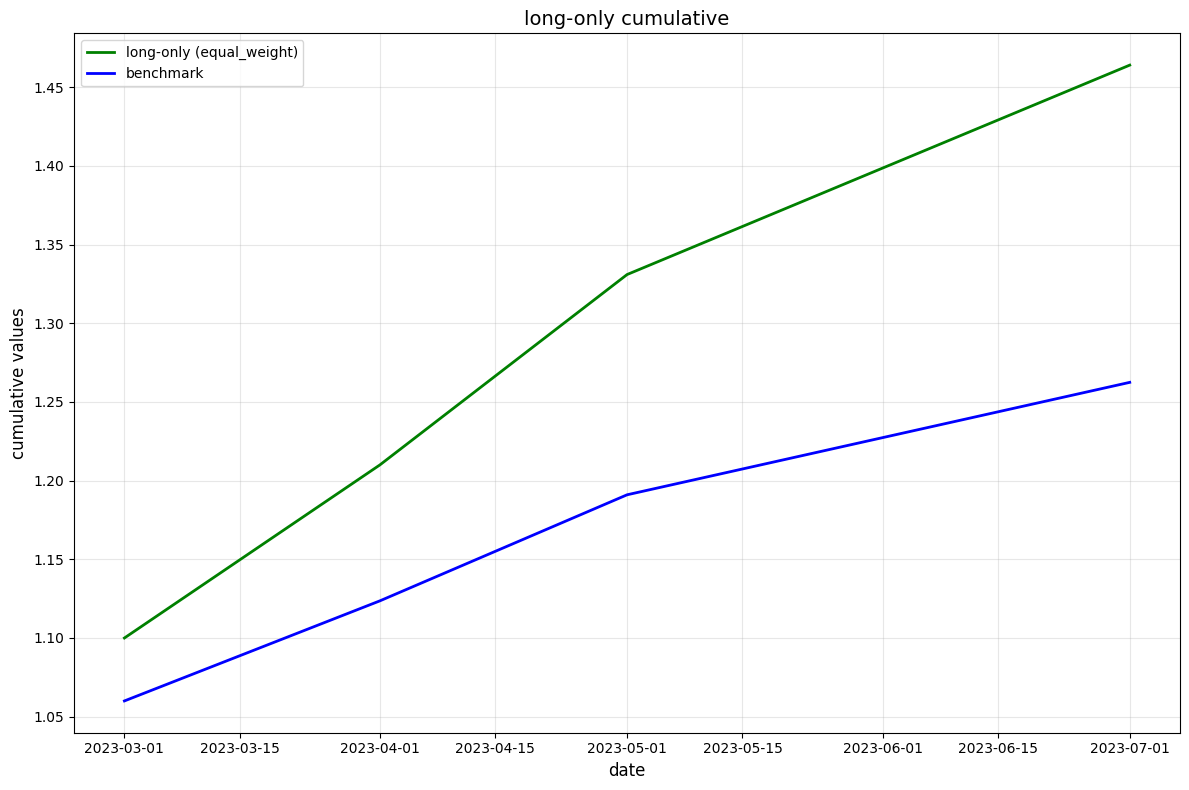

In [10]:
# 绘制纯多组合累计收益图（与基准对比）
moonshot_medium.plot_long_only_returns()

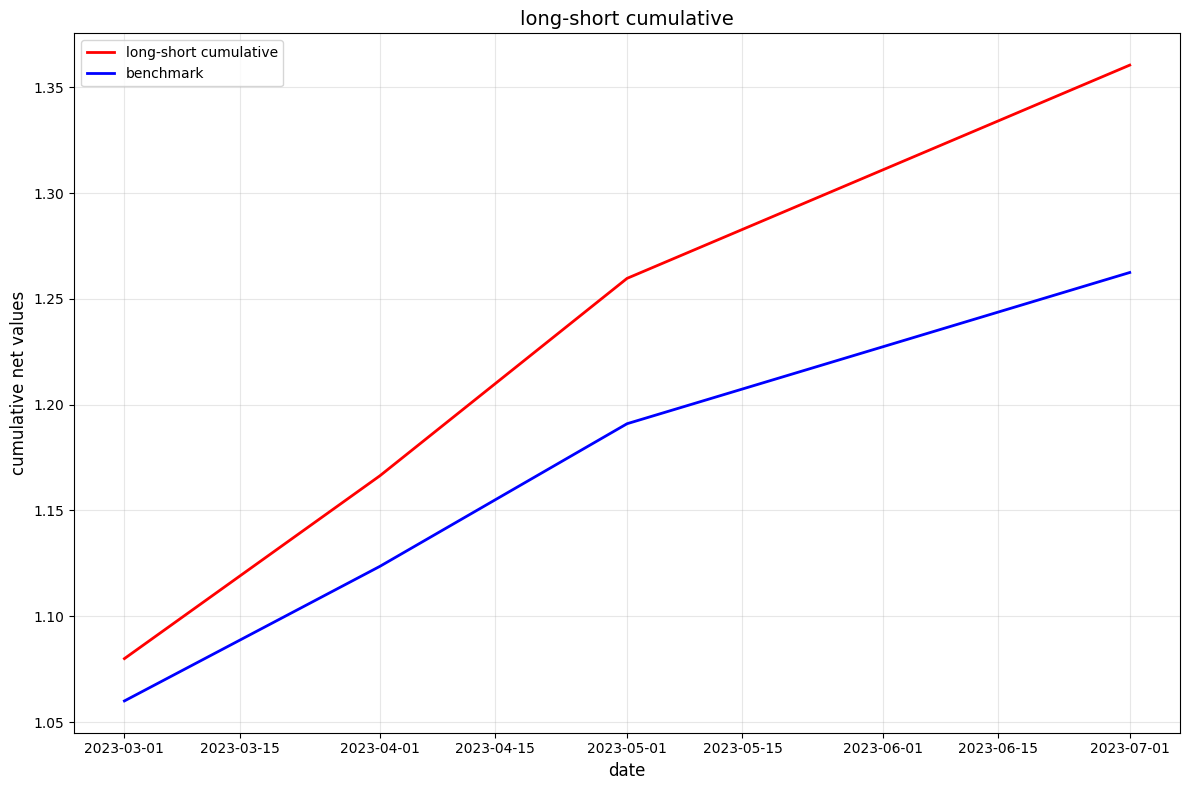

In [11]:
# 绘制多空组合累计收益图（与基准对比）
moonshot_medium.plot_long_short_returns()

In [12]:
# 计算并显示性能指标
metrics_medium = moonshot_medium.calculate_metrics()

# 显示为格式化的表格
print("\n=== 格式化的性能指标表 ===")
display(metrics_medium.round(4))


=== 格式化的性能指标表 ===


,long-short,long-only,optimal,benchmark
Ann. Returns,0.9600,1.2000,1.2000,0.7200
Ann. Vol,0.0000,0.0000,0.0000,0.0000
Sharpe,0.0000,0.0000,0.0000,0.0000
Max DrawDonw,0.0000,0.0000,0.0000,0.0000
Win Rate,1.0000,1.0000,1.0000,1.0000
Sortino,0.0000,0.0000,0.0000,0.0000
Calmar,0.0000,0.0000,0.0000,0.0000
CAGR,1.5182,2.1384,2.1384,1.0122
Alpha,0.9600,1.2000,1.2000,0.7200
Beta,0.0000,0.0000,0.0000,0.0000


## 4. 示例3：使用自定义分组边界（5资产，6个月，自定义bins）

最后，我们演示如何使用自定义的分组边界而不是分位数。

In [14]:
# 使用相同的数据，但采用自定义分组边界
moonshot_bins = Moonshot()

# 使用自定义bins: [0, 2, 4, 6] 将创建3个组
# Bin1: factor <= 2
# Bin2: 2 < factor <= 4
# Bin3: factor > 4
moonshot_bins.backtest(
    factor_series_medium, bars_medium, bins=[0, 2, 4, 6], quantiles = None
)

print("=== 自定义分组边界回测结果 ===")
print("策略收益率:")
print(moonshot_bins.quantile_returns)
print("\n基准收益率:")
print(moonshot_bins.benchmark_returns)

print("\n各组平均收益率:")
print(moonshot_bins.quantile_returns.mean())

print("分组说明:")
print("Bin1: Stock_A, Stock_B (因子值 <= 2)")
print("Bin2: Stock_C, Stock_D (因子值 2 < factor <= 4)")
print("Bin3: Stock_E (因子值 > 4)")

=== 自定义分组边界回测结果 ===
策略收益率:
                               Bin1  Bin2  Bin3
2023-02-28 23:59:59.999999999  0.03  0.07   0.1
2023-03-31 23:59:59.999999999  0.03  0.07   0.1
2023-04-30 23:59:59.999999999  0.03  0.07   0.1
2023-06-30 23:59:59.999999999  0.03  0.07   0.1

基准收益率:
2023-02-28 23:59:59.999999999    0.06
2023-03-31 23:59:59.999999999    0.06
2023-04-30 23:59:59.999999999    0.06
2023-06-30 23:59:59.999999999    0.06
Name: Benchmark, dtype: float64

各组平均收益率:
Bin1    0.03
Bin2    0.07
Bin3    0.10
dtype: float64
分组说明:
Bin1: Stock_A, Stock_B (因子值 <= 2)
Bin2: Stock_C, Stock_D (因子值 2 < factor <= 4)
Bin3: Stock_E (因子值 > 4)


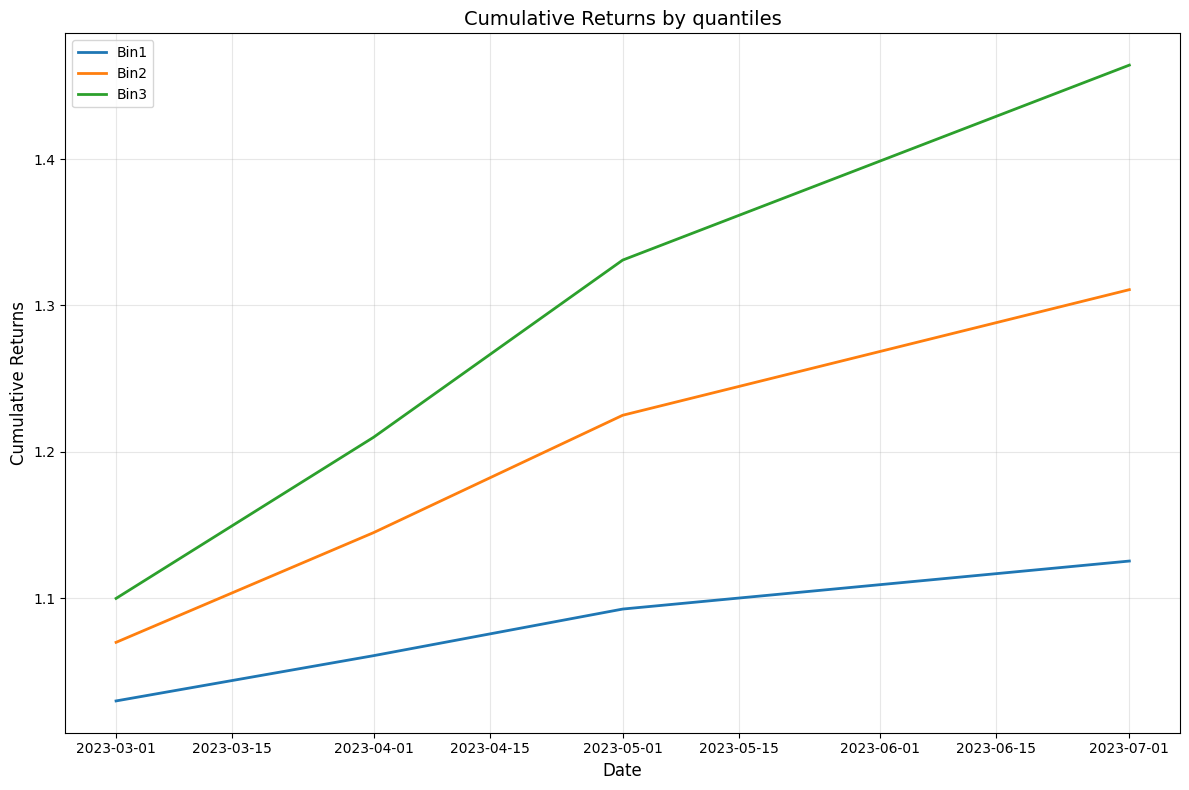

In [16]:
# 绘制自定义分组的累计收益图
moonshot_bins.plot_cumulative_returns_by_quantiles()

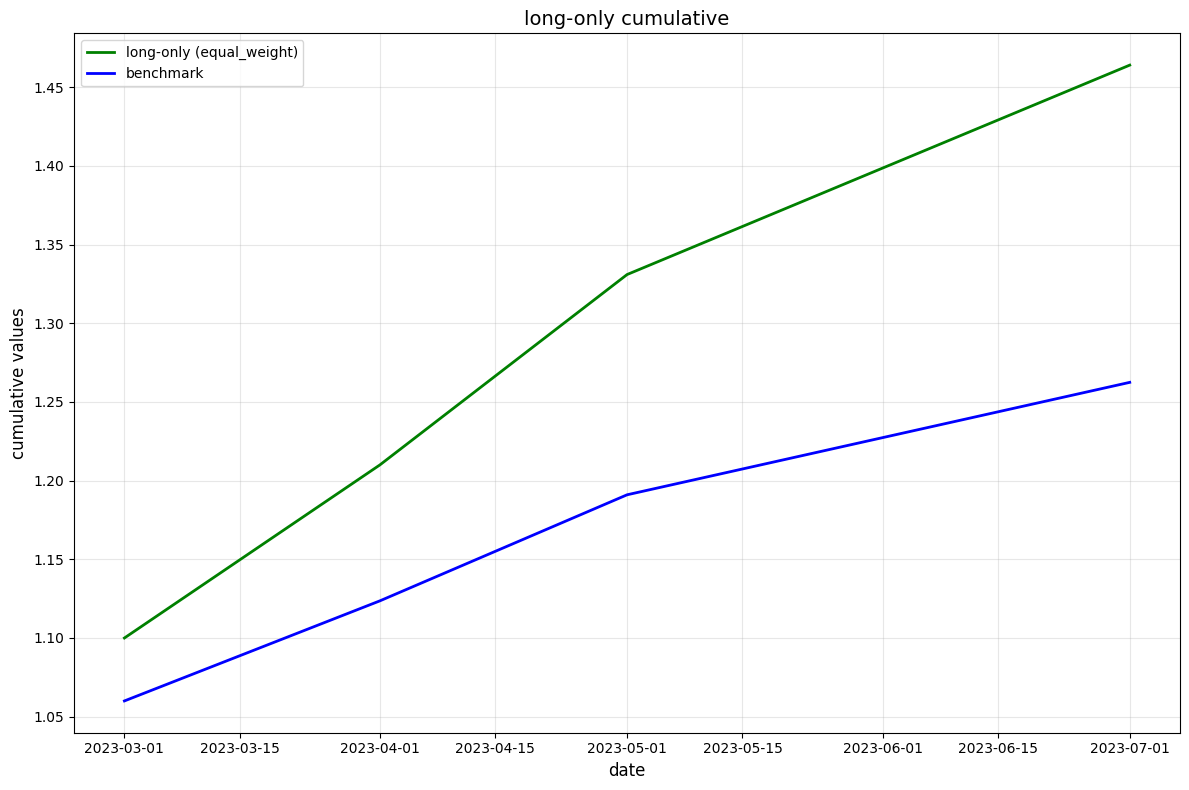

In [18]:
# 绘制纯多组合累计收益图
moonshot_bins.plot_long_only_returns()

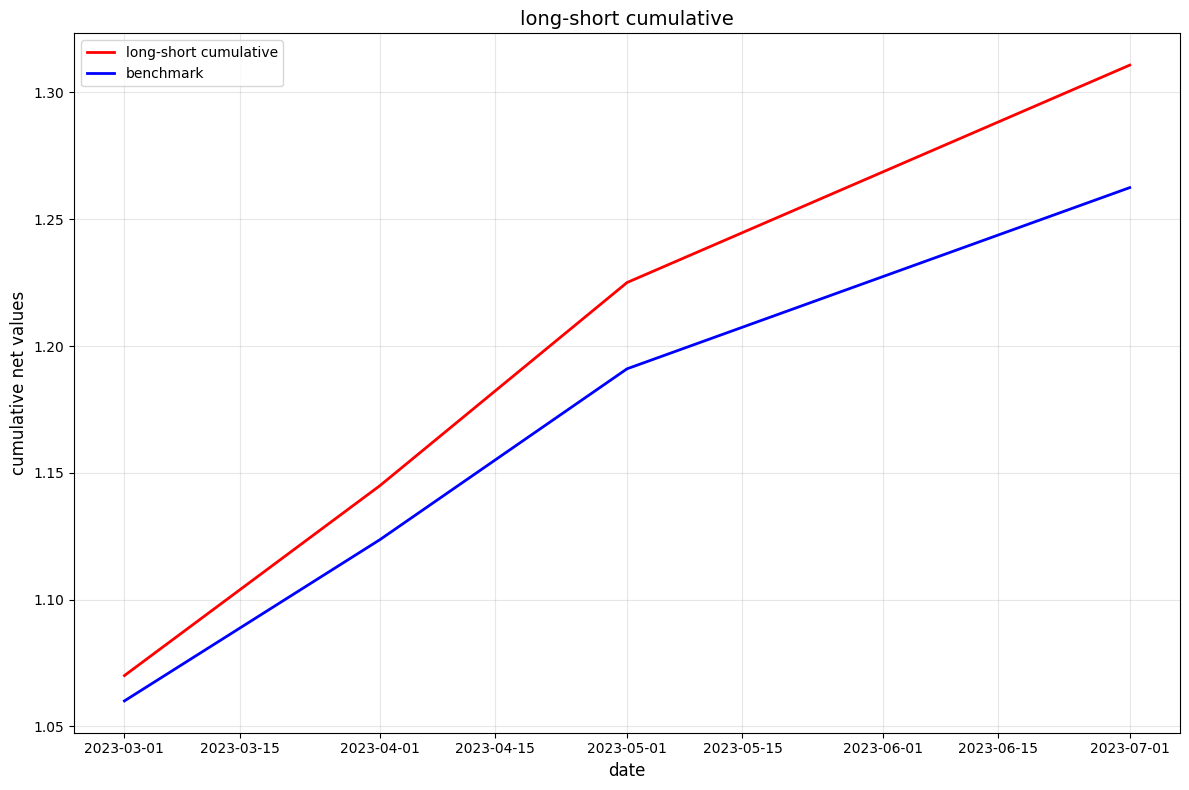

In [19]:
# 绘制多空组合累计收益图
moonshot_bins.plot_long_short_returns()

In [20]:
# 计算并显示性能指标
metrics_bins = moonshot_bins.calculate_metrics()

## 5. 总结

通过以上三个示例，我们展示了Moonshot框架的主要功能：

1. **简单验证示例**：使用最简单的数据验证计算逻辑的正确性
2. **中等复杂度示例**：展示多资产、多时间段的回测分析
3. **自定义分组示例**：演示如何使用自定义分组边界

### 主要功能特性：

- **面向对象设计**：使用Moonshot类，便于管理回测状态和结果
- **灵活的分组方式**：支持分位数分组和自定义边界分组
- **丰富的可视化**：提供分组收益、纯多组合、多空组合的累计收益图
- **全面的性能指标**：计算年化收益、夏普比率、最大回撤等多种指标
- **基准对比**：所有分析都包含与基准的对比
- **向后兼容**：保留原有函数接口，确保现有代码继续可用

### 使用建议：

1. 对于新项目，推荐使用Moonshot类的面向对象接口
2. 在进行因子有效性分析时，重点关注多空组合的表现
3. 使用性能指标表格进行量化的策略评估
4. 结合可视化图表进行直观的结果展示

## 6. 因子加权策略收益计算

### 6.1 等权重 vs 因子加权对比

除了传统的等权重分组方法，Moonshot现在支持基于因子值的加权方法，这种方法能更好地利用因子的连续性信息。

**两种加权方法：**

1. **等权重方法** (`weighting_method='equal_weight'`)：
   - 将股票按因子值分组，每组内股票等权重
   - 适合因子有效性验证
   - 计算简单，结果稳定

2. **因子加权方法** (`weighting_method='factor_weight'`)：
   - 直接使用因子值作为权重
   - 纯多组合：因子值归一化后作为权重
   - 多空组合：因子值去均值化并归一化后作为权重
   - 更好地利用因子连续性信息

In [21]:
# 使用因子加权方法进行回测
print("=== 因子加权方法回测 ===")

moonshot_fw = Moonshot()
strategy_fw, benchmark_fw = moonshot_fw.backtest(
    factor_series_medium, bars_medium, 
    quantiles=5, 
    weighting_method='factor_weight'
)

print("因子加权策略收益率（前3期）:")
print(strategy_fw.head(3))
print(f"\n因子加权基准收益率（前3期）:")
print(benchmark_fw.head(3))

# 显示新增的因子加权收益序列
print(f"\n纯多组合收益率（前3期）:")
print(moonshot_fw.long_only_returns.head(3))
print(f"\n多空组合收益率（前3期）:")
print(moonshot_fw.long_short_returns.head(3))

=== 因子加权方法回测 ===


TypeError: cannot unpack non-iterable Moonshot object

### 6.2 因子加权方法的计算原理

让我们详细解释因子加权方法的计算过程：

In [22]:
# 演示因子加权的计算过程
print("=== 因子加权计算原理演示 ===")

# 使用第一个月的数据作为示例
first_month_factor = factor_series_medium.loc['2023-01-31']
print("第一个月的因子值:")
print(first_month_factor)

# 纯多组合权重计算
factor_values = first_month_factor.values
long_only_weights = np.abs(factor_values) / np.sum(np.abs(factor_values))
print("纯多组合权重（因子值归一化）:")
for asset, weight in zip(first_month_factor.index, long_only_weights):
    print(f"{asset}: {weight:.4f}")

# 多空组合权重计算
demeaned_factors = factor_values - np.mean(factor_values)
long_short_weights = demeaned_factors / np.sum(np.abs(demeaned_factors))
print("\n多空组合权重（因子值去均值化并归一化）:")
for asset, weight in zip(first_month_factor.index, long_short_weights):
    print(f"{asset}: {weight:+.4f}")

print("\n说明:")
print("- 纯多组合：所有权重为正，因子值越大权重越大")
print("- 多空组合：权重有正有负，高于平均因子值的为正权重（做多），低于平均的为负权重（做空）")

=== 因子加权计算原理演示 ===
第一个月的因子值:
asset
Stock_A    1.0
Stock_B    2.0
Stock_C    3.0
Stock_D    4.0
Stock_E    5.0
Name: factor, dtype: float64
纯多组合权重（因子值归一化）:
Stock_A: 0.0667
Stock_B: 0.1333
Stock_C: 0.2000
Stock_D: 0.2667
Stock_E: 0.3333

多空组合权重（因子值去均值化并归一化）:
Stock_A: -0.3333
Stock_B: -0.1667
Stock_C: +0.0000
Stock_D: +0.1667
Stock_E: +0.3333

说明:
- 纯多组合：所有权重为正，因子值越大权重越大
- 多空组合：权重有正有负，高于平均因子值的为正权重（做多），低于平均的为负权重（做空）


### 6.3 因子加权方法的可视化对比

NameError: name 'moonshot_eq' is not defined

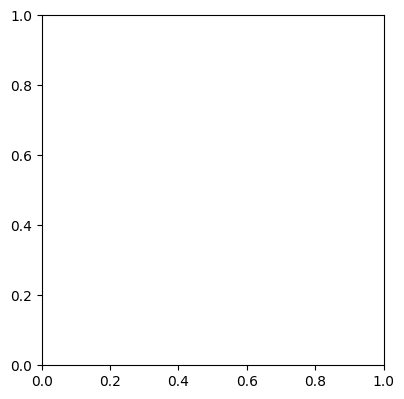

In [23]:
# 绘制等权重方法的累计收益图
plt.figure(figsize=(15, 10))

# 等权重分组收益
plt.subplot(2, 3, 1)
moonshot_eq.plot_group_returns()
plt.title('等权重：各分位数组合累计收益')

# 等权重纯多组合
plt.subplot(2, 3, 2)
moonshot_eq.plot_long_only_returns()
plt.title('等权重：纯多组合 vs 基准')

# 等权重多空组合
plt.subplot(2, 3, 3)
moonshot_eq.plot_long_short_returns()
plt.title('等权重：多空组合 vs 基准')

# 因子加权分组收益
plt.subplot(2, 3, 4)
moonshot_fw.plot_group_returns()
plt.title('因子加权：各分位数组合累计收益')

# 因子加权纯多组合
plt.subplot(2, 3, 5)
moonshot_fw.plot_long_only_returns()
plt.title('因子加权：纯多组合 vs 基准')

# 因子加权多空组合
plt.subplot(2, 3, 6)
moonshot_fw.plot_long_short_returns()
plt.title('因子加权：多空组合 vs 基准')

plt.tight_layout()
plt.show()

### 6.4 性能指标对比

In [24]:
# 计算两种方法的性能指标
print("=== 等权重方法性能指标 ===")
metrics_eq = moonshot_eq.calculate_metrics()
display(metrics_eq.round(4))

print("\n=== 因子加权方法性能指标 ===")
metrics_fw = moonshot_fw.calculate_metrics()
display(metrics_fw.round(4))

=== 等权重方法性能指标 ===


NameError: name 'moonshot_eq' is not defined

In [25]:
# 对比分析
print("=== 两种方法的对比分析 ===")

# 提取关键指标进行对比
comparison_data = {
    '指标': ['年化收益率', '年化波动率', '夏普比率', '最大回撤'],
    '等权重_多空组合': [
        metrics_eq.loc['年化收益率', '多空组合 (equal_weight)'],
        metrics_eq.loc['年化波动率', '多空组合 (equal_weight)'],
        metrics_eq.loc['夏普比率', '多空组合 (equal_weight)'],
        metrics_eq.loc['最大回撤', '多空组合 (equal_weight)']
    ],
    '因子加权_多空组合': [
        metrics_fw.loc['年化收益率', '多空组合 (factor_weight)'],
        metrics_fw.loc['年化波动率', '多空组合 (factor_weight)'],
        metrics_fw.loc['夏普比率', '多空组合 (factor_weight)'],
        metrics_fw.loc['最大回撤', '多空组合 (factor_weight)']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['改善幅度'] = (comparison_df['因子加权_多空组合'] - comparison_df['等权重_多空组合']) / comparison_df['等权重_多空组合'] * 100

print("多空组合策略对比:")
display(comparison_df.round(4))

print("\n结论:")
print("- 因子加权方法能更好地利用因子的连续性信息")
print("- 在因子有效的情况下，因子加权通常能获得更好的风险调整收益")
print("- 等权重方法更适合因子有效性验证，因子加权更适合实际策略构建")

=== 两种方法的对比分析 ===


NameError: name 'metrics_eq' is not defined

### 6.5 使用建议

**何时使用等权重方法：**
- 因子有效性验证
- 学术研究和因子分析
- 需要稳定、可解释的结果

**何时使用因子加权方法：**
- 实际策略构建
- 追求更高的信息比率
- 因子值具有良好的连续性

**注意事项：**
- 因子加权方法对异常值更敏感
- 建议在使用前对因子值进行适当的预处理（如去极值、标准化）
- 两种方法可以结合使用，先用等权重验证因子有效性，再用因子加权构建策略

### 6.6 因子滞后参数演示

In [ ]:
# 演示不同的因子滞后参数
print("=== 因子滞后参数对比 ===")

# 因子滞后1个月（默认）
moonshot_lag1 = Moonshot()
strategy_returns_lag1, _ = moonshot_lag1.backtest(
    factor_series_medium, bars_medium, quantiles=5, factor_lag=1
)

# 因子滞后2个月
moonshot_lag2 = Moonshot()
strategy_returns_lag2, _ = moonshot_lag2.backtest(
    factor_series_medium, bars_medium, quantiles=5, factor_lag=2
)

print(f"因子滞后1个月的交易期数: {len(strategy_returns_lag1)}")
print(f"因子滞后2个月的交易期数: {len(strategy_returns_lag2)}")
print("\n说明：更高的滞后期会减少可用的交易期数，但可能更符合实际交易中的信息滞后情况。")